## Code produit avec l'article: 
https://medium.com/h7w/implementing-a-variational-autoencoder-with-keras-e19d7140ad90

### On applique le whitening sur les images

In [1]:
from keras.layers import Conv1D, Conv2D, Input, Flatten, Dense, MaxPooling1D, MaxPooling2D, BatchNormalization, Concatenate
from keras.optimizers import Adam
from keras import layers
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf
from PIL import Image
import copy
import numpy as np
import keras
import os
import re



In [2]:
# Fonction pour calculer les coordonées stéréographiques

def stereo(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    # Projection sur x y
    px = x / (1 + z + 1e-8)
    py = y / (1 + z + 1e-8)
    return px, py

# Importation des images

In [29]:
# Dossier contenant les images
repertoire = "../Render/captures"
img_width, img_height = 50, 50

# Expression pour extraire les infos du nom de fichier
#pattern = re.compile(r"img_tv(\d+)_pv(\d+)_tl(\d+)_pl(\d+)\.png") #all
pattern = re.compile(r"img_tv0_pv0_tl(\d+)_pl(\d+)\.jpg") #les images avec tv = 45 (la latitude moyenne)

# Stockage des résultats
images_info = []
# Pour calculer la moyenne et la variance
later = []


for nom_fichier in os.listdir(repertoire):
    if nom_fichier.endswith(".jpg"):
        match = pattern.match(nom_fichier)
        if match:
            tl, pl = match.groups()
            tl, pl = int(tl), int(pl)
            px, py = stereo(np.radians(tl), np.radians(pl)) # Calcul des coordonnées stéréo
            chemin_image = os.path.join(repertoire, nom_fichier)
            image = Image.open(chemin_image)
            w, h = image.size
            left = (w - img_width) / 2
            top = (h - img_height) / 2
            right = (w + img_width) / 2
            bottom = (h + img_height) / 2
            #left, top, right, bottom = int(left), int(top), int(right), int(bottom)
            image = Image.open(chemin_image).crop((left, top, right, bottom))
            pixels = np.array(image, dtype=np.float32)

            # Traitement image, epsilon pour que log soit strictement définni
            pixels_log_transformed = np.log(pixels + 1e-6)
            later.append(pixels_log_transformed)

            images_info.append({
                "tl": tl,
                "pl": pl,
                "px": px,
                "py": py,
                "image": image,
                "pixels": pixels,
            })

# Exemple : affichage d'une info
for info in images_info[:5]:  # juste les 5 premières
    print(f"tl={info['tl']}, pl={info['pl']}, px={info['px']}, py={info['py']}")
print(images_info[0]['pixels'][0, 0])

tl=75, pl=345, px=0.7411809490095723, py=-0.198598836732448
tl=75, pl=225, px=-0.5425821122771244, py=-0.5425821122771243
tl=60, pl=252, px=-0.17841104369713806, py=-0.5490927320369364
tl=30, pl=120, px=-0.13397459549759358, py=0.23205080632532074
tl=45, pl=160, px=-0.3892334257113643, py=0.14166938114040184
[ 22.  32. 119.]


In [30]:
combined_log_pixels = np.concatenate([arr.flatten() for arr in later])

global_mean = np.mean(combined_log_pixels)
global_std = np.std(combined_log_pixels)

# éviter la division par zéro
if global_std < 1e-6: global_std = 1e-6 

# Blanchissement
for i, info in enumerate(images_info):
    # Formule donnée par Rainer: (x - mean) / std
    images_info[i]["pixels"] = (info["pixels"] - global_mean) / global_std

# Example: affichage d'une info et vérification des formes après traitement
for info in images_info[:5]:  # juste les 5 premières
    print(f"Après traitement: tl={info['tl']}, pl={info['pl']}, px={info['px']}, py={info['py']}, pixels_shape={info['pixels'].shape}")
print(images_info[0]['pixels'][0, 0])

Après traitement: tl=75, pl=345, px=0.7411809490095723, py=-0.198598836732448, pixels_shape=(50, 50, 3)
Après traitement: tl=75, pl=225, px=-0.5425821122771244, py=-0.5425821122771243, pixels_shape=(50, 50, 3)
Après traitement: tl=60, pl=252, px=-0.17841104369713806, py=-0.5490927320369364, pixels_shape=(50, 50, 3)
Après traitement: tl=30, pl=120, px=-0.13397459549759358, py=0.23205080632532074, pixels_shape=(50, 50, 3)
Après traitement: tl=45, pl=160, px=-0.3892334257113643, py=0.14166938114040184, pixels_shape=(50, 50, 3)
[ 23.723246  36.969814 152.21495 ]


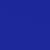

In [31]:
images_info[2]['image']

In [42]:
images_info[0]['pixels'].shape

(50, 50, 3)

In [59]:
all_whitened_pixels = []
for info in images_info:
    all_whitened_pixels.append(info['pixels'])

all_whitened_pixels_flat = np.concatenate([img.flatten() for img in all_whitened_pixels])
min_val = all_whitened_pixels_flat.min()
max_val = all_whitened_pixels_flat.max()


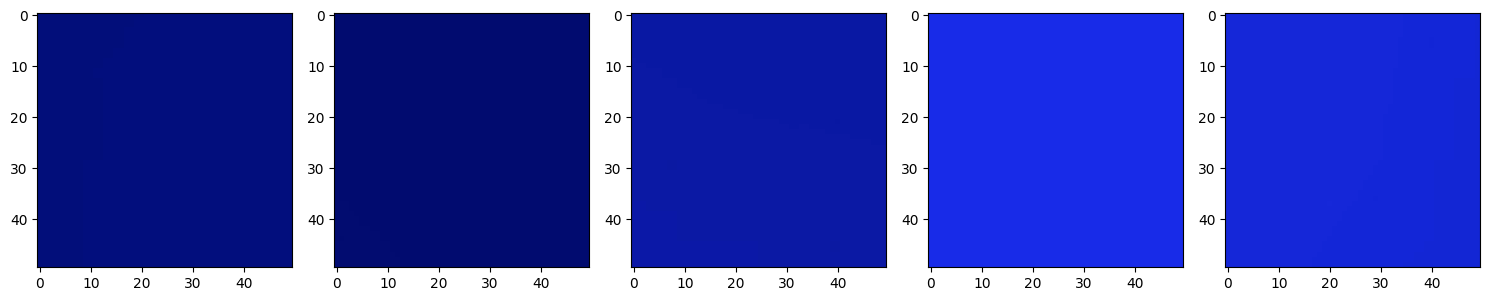

In [65]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): 
    # Traitement inverse pour afficher les images
    image_traitee = copy.deepcopy(images_info[i]['pixels'])
    display_data = (image_traitee - min_val) / (max_val - min_val)     # On remet entre 0 et 1
    axes[i].imshow(display_data)
plt.tight_layout()
plt.show()

# On trie la liste

In [66]:
sorted = copy.deepcopy(images_info)
sorted.sort(key=lambda d: (d["tl"], d["pl"]))

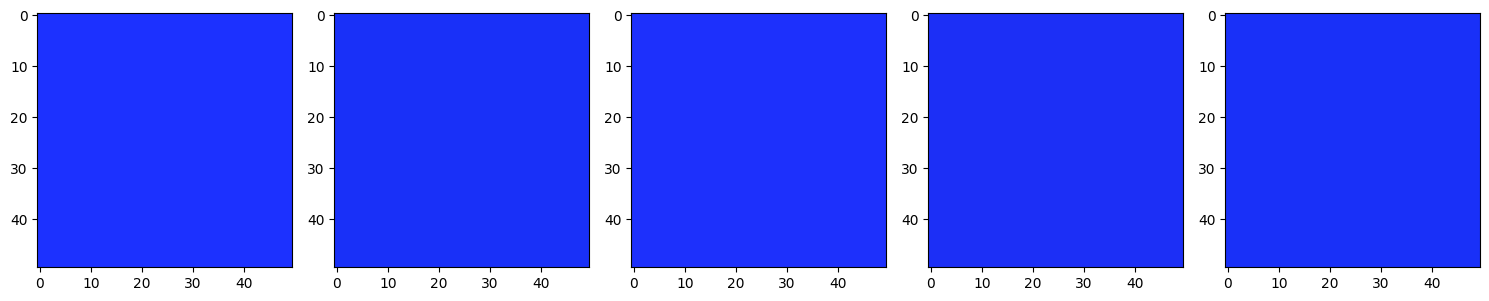

In [70]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): 
    # Traitement inverse pour afficher les images
    image_traitee = copy.deepcopy(sorted[i]['pixels'])
    display_data = (image_traitee - min_val) / (max_val - min_val)     # On remet entre 0 et 1
    axes[i].imshow(display_data)
plt.tight_layout()
plt.show()

In [71]:
images_info[0]['pixels'][0, 0]

array([ 23.723246,  36.969814, 152.21495 ], dtype=float32)

In [73]:
print("Premier pixel de la troisième image (R,G,B) :", images_info[2]['pixels'][0][0])
print("Nombre d'images importées:", len(images_info))

Premier pixel de la troisième image (R,G,B) : [ 31.671186  47.567062 195.92863 ]
Nombre d'images importées: 81


# Création du modèles

In [74]:
latent_dim = 8 # Dimension du bottleneck
num_channels = 3 # RGB
samples = len(images_info) # Nombre de configuration angulaires
matrix_H = 9
matrix_W = 9

input_shape = (matrix_H, matrix_W, num_channels)

# Definition
i = Input(shape=input_shape, name='encoder_input')

# Bloc 1 (Conv1D -> Conv2D, MaxPooling1D -> MaxPooling2D)
x = Conv2D(filters = 64, kernel_size=(3, 3), padding='same', activation='relu')(i)
x = BatchNormalization()(x) #weight decay
x = MaxPooling2D(pool_size=(2, 2))(x)

# Projection
x = Flatten()(x)
latent_output = Dense(latent_dim, name='latent_output')(x)

# Modèle
encoder_model_light = Model(inputs=i, outputs=latent_output, name="EncoderLight")
encoder_model_light.summary()

Model: "EncoderLight"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 9, 9, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 9, 9, 64)       │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_output (Dense)           │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,248 (40.03 KB)

 Trainable params: 10,120 (39.53 KB)

 Non-trainable params: 128 (512.00 B)

In [75]:
# =================
# Decoder
# =================

# Paramètres
angle_dim = 2  # 2 pour lumière
input_dim = latent_dim + angle_dim  # 8 + 2 = 10

# Entrée
decoder_input = Input(shape=(input_dim,), name='decoder_input')

# 4 couches Fully Connected avec ReLU
x = Dense(106, activation='relu')(decoder_input)

x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)

# Sortie RGB (3 valeurs)
decoder_output = Dense(3, activation='linear', name='rgb_output')(x)

# Modèle
decoder_model = Model(inputs=decoder_input, outputs=decoder_output, name="Decoder")
decoder_model.summary()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 106)            │         1,166 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rgb_output (Dense)              │ (None, 3)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,513 (138.72 KB)

 Trainable params: 35,513 (138.72 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
# =================
# VAE
# =================
view_light_input = Input(shape=(angle_dim,), name='view_light_input')
latent_vector = encoder_model_light(i)
decoder_input = Concatenate()([latent_vector, view_light_input])
vae_outputs = decoder_model(decoder_input)

vae = Model(inputs=[i, view_light_input], outputs=vae_outputs, name='VAE')
vae.summary()

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 9, 9, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EncoderLight        │ (None, 8)         │     10,248 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ view_light_input    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10)        │          0 │ EncoderLight[0][… │
│ (Concatenate)       │                   │            │ view_light_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ (None, 3)         │     35,513 │ concatenate[0][0] │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,761 (178.75 KB)

 Trainable params: 45,633 (178.25 KB)

 Non-trainable params: 128 (512.00 B)

In [77]:
# --- L2 Loss ---
def custom_reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


In [78]:
decoder_weights_path = os.path.join('modeles/', 'my_decoder.weights.h5')
decoder_model.save_weights(decoder_weights_path)
print(f"Poids de l'Encodeur sauvegardés à : {decoder_weights_path}")

Poids de l'Encodeur sauvegardés à : modeles/my_decoder.weights.h5


# Compilation et entraînement
Sur un seul texel pour commencer

In [79]:
# on prend toutes les images
image_stack = np.stack([info["pixels"] for info in images_info], axis=0)
# image_stack.shape = (N_images, height, width, 3)

In [80]:
# on fait de même avec les angles
tl_stack = np.stack([info["tl"] for info in images_info], axis=0)
pl_stack = np.stack([info["pl"] for info in images_info], axis=0)

# et pour les positions stéréo
px_stack = np.stack([info["px"] for info in images_info], axis=0)
py_stack = np.stack([info["py"] for info in images_info], axis=0)

In [81]:
# Préparation des données

# Choisir UN texel
texel_position = (0, 0)
texel_observations = image_stack[:, texel_position[0], texel_position[1]] # (samples, num_channels) ex: (81, 3)

padded_observations = np.zeros((matrix_H * matrix_W, num_channels))
padded_observations[:len(texel_observations)] = texel_observations

input_train_batch_2d = padded_observations.reshape((1, matrix_H, matrix_W, num_channels))
target_rgb_train = texel_observations  # (81, 3)
light_dirs = np.stack([px_stack, py_stack], axis=1) # Forme (81, 2)

In [82]:
input_train_batch_2d.shape

(1, 9, 9, 3)

# Pre train avant d'utiliser les valeurs de shapley

In [83]:
custom_optimizer = Adam(learning_rate=0.01) # Adam est une version améliorée de la descente de gradient stochastique, par défaut on avait 0.001
vae.compile(custom_optimizer, loss=lambda y_true, y_pred: custom_reconstruction_loss(y_true, y_pred))

history_vae = vae.fit([np.repeat(input_train_batch_2d, samples, axis=0), light_dirs], target_rgb_train,
        epochs=50, batch_size=5, validation_split=0.2)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10439.9922 - val_loss: 1325823.7500
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2233.3645 - val_loss: 338321.9375
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1237.3373 - val_loss: 374851.0312
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1127.9658 - val_loss: 209745.3125
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1197.5011 - val_loss: 124986.5312
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1917.3180 - val_loss: 39941.6523
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1834.7101 - val_loss: 57116.5820
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1640.6709 - val_loss: 143534.0469
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2099.9355 - val_loss: 25567.6465
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1487.6046 - val_loss: 18224.5645
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1901.2648 - val_loss:

dict_keys(['loss', 'val_loss'])


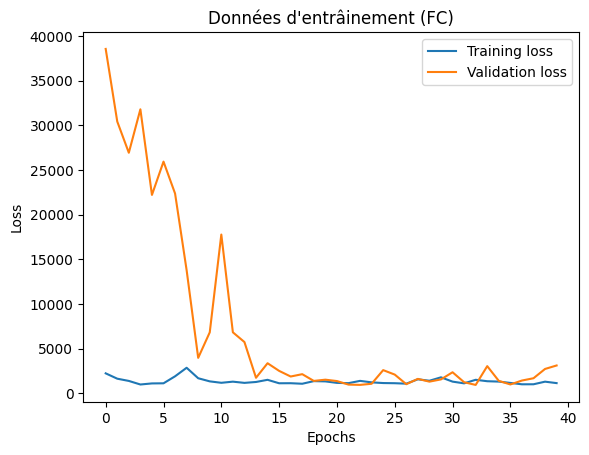

In [84]:
# Evaluer l'apprentissage d'un modèle --Code: Patrick Reuter--
def montrerCourbesApprentissage(history):
    #list all data in history
    print(history.history.keys())

    plt.plot(history.history['loss'][10:], label="Training loss")
    plt.plot(history.history['val_loss'][10:], label="Validation loss")

    plt.title("Données d'entrâinement (FC)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

montrerCourbesApprentissage(history_vae)